In [49]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [7]:

# Load the dataset
data = pd.read_csv('movies_metadata.csv')  # Replace 'movie_dataset.csv' with the actual file name

/var/folders/cv/kmsppstx0d9281mtbqrrgl6c0000gn/T/ipykernel_35671/297781075.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('movies_metadata.csv')  # Replace 'movie_dataset.csv' with the actual file name


In [8]:
data.shape

(45466, 24)

In [9]:
data.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [10]:
data = data[['overview', 'genres']]

In [11]:
data['genres_count'] = data['genres'].apply(lambda x: len(eval(x)))

<AxesSubplot:>

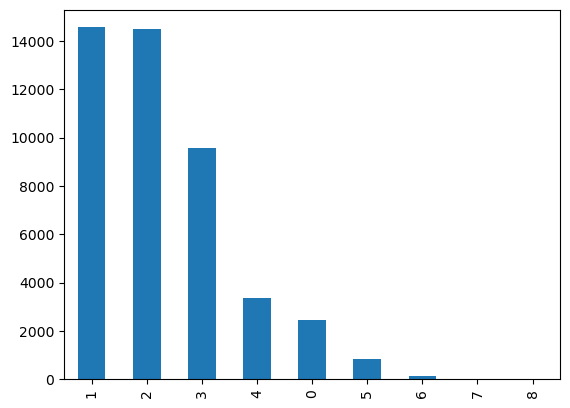

In [12]:
data['genres_count'].value_counts().plot(kind = 'bar')

In [13]:
data = data[data['genres_count']>0]

In [14]:
data = data.dropna(subset = ['overview'])

In [15]:
data.shape

(42327, 3)

In [16]:
def parse(x):
    names = []
    x = eval(x)
    for dictionary in x:
        names.append(dictionary['name'])
    return names

In [17]:
data['target'] = data['genres'].apply(parse)

In [18]:
data['genres'].head(),data['target'].head()

(0     [{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]
 1    [{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]
 2                                     [{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]
 3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]
 4                                                                       [{'id': 35, 'name': 'Comedy'}]
 Name: genres, dtype: object,
 0     [Animation, Comedy, Family]
 1    [Adventure, Fantasy, Family]
 2               [Romance, Comedy]
 3        [Comedy, Drama, Romance]
 4                        [Comedy]
 Name: target, dtype: object)

In [19]:
data.head()

,overview,genres,genres_count,target
0,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their diffe...","[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",3,"[Animation, Comedy, Family]"
1,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all ...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]",3,"[Adventure, Fantasy, Family]"
2,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in ...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]",2,"[Romance, Comedy]"
3,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",3,"[Comedy, Drama, Romance]"
4,"Just when George Banks has recovered from his daughter's wedding, he receives the news that she's pregnant ... and that George's wife, Nina, is expecting too. He was planning on selling their home, but that's a plan that -- like George -- will have to change with the arrival of both a grandchild...","[{'id': 35, 'name': 'Comedy'}]",1,[Comedy]


In [22]:
genres = data['target']
# get all genre tags in a list
all_genres = sum(genres,[])
len(set(all_genres))

32

In [23]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

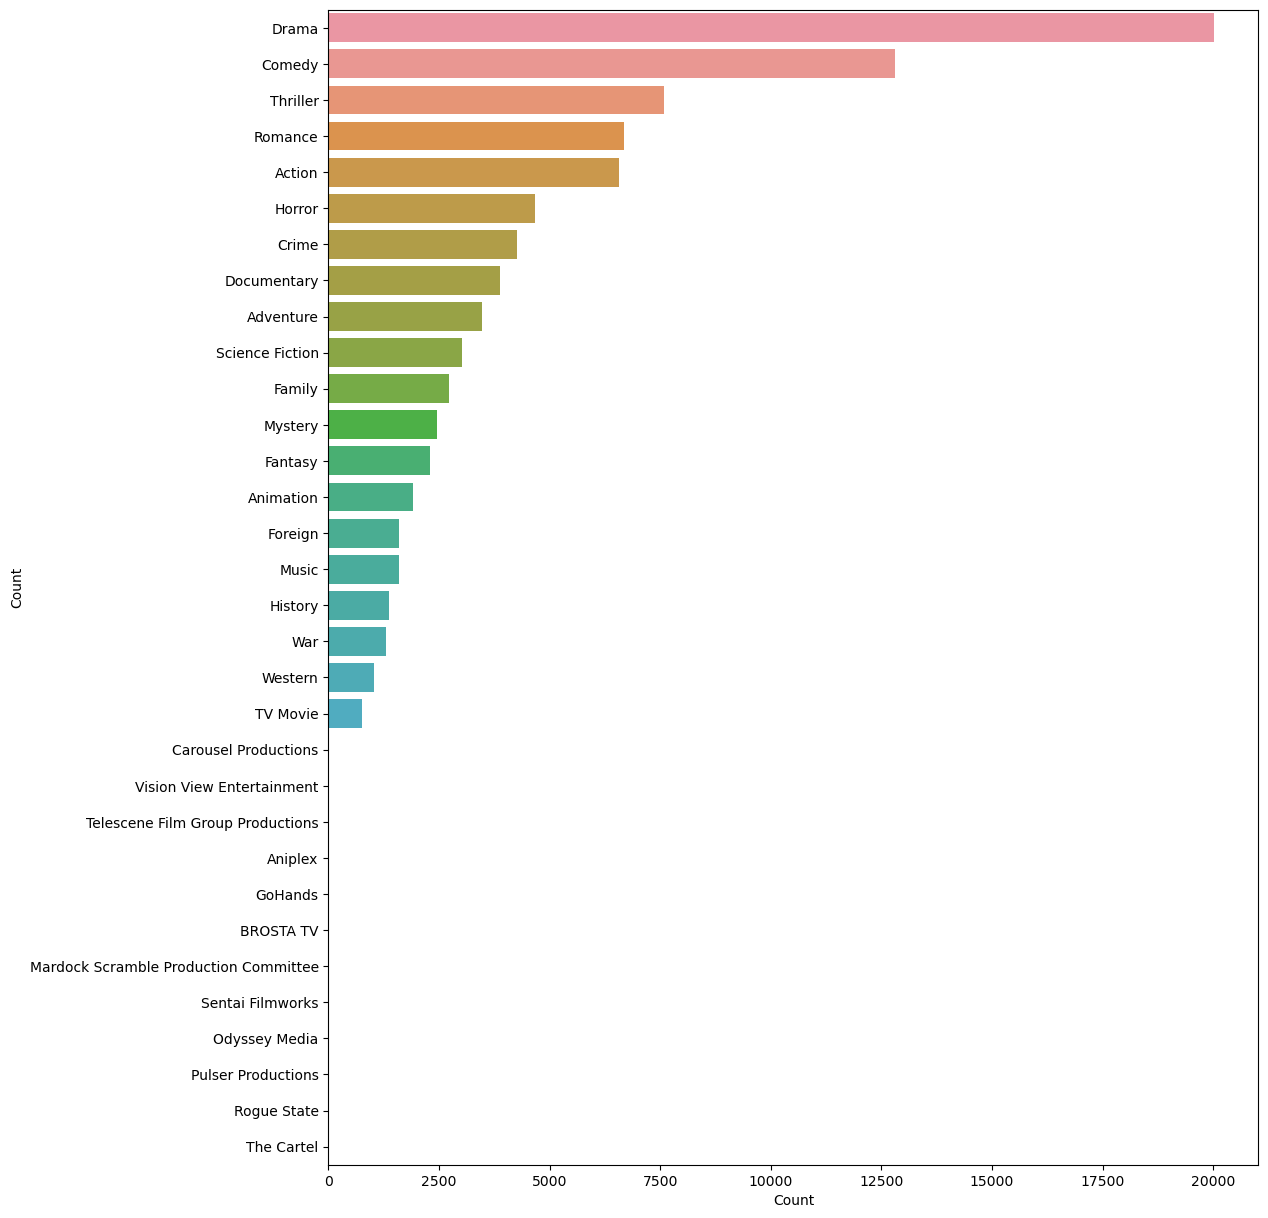

In [24]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [25]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [26]:
data['overview_clean'] = data['overview'].apply(lambda x: clean_text(x))


In [27]:
data.head()

,overview,genres,genres_count,target,overview_clean
0,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their diffe...","[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",3,"[Animation, Comedy, Family]",led by woody andys toys live happily in his room until andys birthday brings buzz lightyear onto the scene afraid of losing his place in andys heart woody plots against buzz but when circumstances separate buzz and woody from their owner the duo eventually learns to put aside their differences
1,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all ...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]",3,"[Adventure, Fantasy, Family]",when siblings judy and peter discover an enchanted board game that opens the door to a magical world they unwittingly invite alan an adult whos been trapped inside the game for years into their living room alans only hope for freedom is to finish the game which proves risky as all three find the...
2,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in ...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]",2,"[Romance, Comedy]",a family wedding reignites the ancient feud between next door neighbors and fishing buddies john and max meanwhile a sultry italian divorc e opens a restaurant at the local bait shop alarming the locals who worry shell scare the fish away but shes less interested in seafood than she is in cookin...
3,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",3,"[Comedy, Drama, Romance]",cheated on mistreated and stepped on the women are holding their breath waiting for the elusive good man to break a string of less than stellar lovers friends and confidants vannah bernie glo and robin talk it all out determined to find a better way to breathe
4,"Just when George Banks has recovered from his daughter's wedding, he receives the news that she's pregnant ... and that George's wife, Nina, is expecting too. He was planning on selling their home, but that's a plan that -- like George -- will have to change with the arrival of both a grandchild...","[{'id': 35, 'name': 'Comedy'}]",1,[Comedy],just when george banks has recovered from his daughters wedding he receives the news that shes pregnant and that georges wife nina is expecting too he was planning on selling their home but thats a plan that like george will have to change with the arrival of both a grandchild and a kid of his own


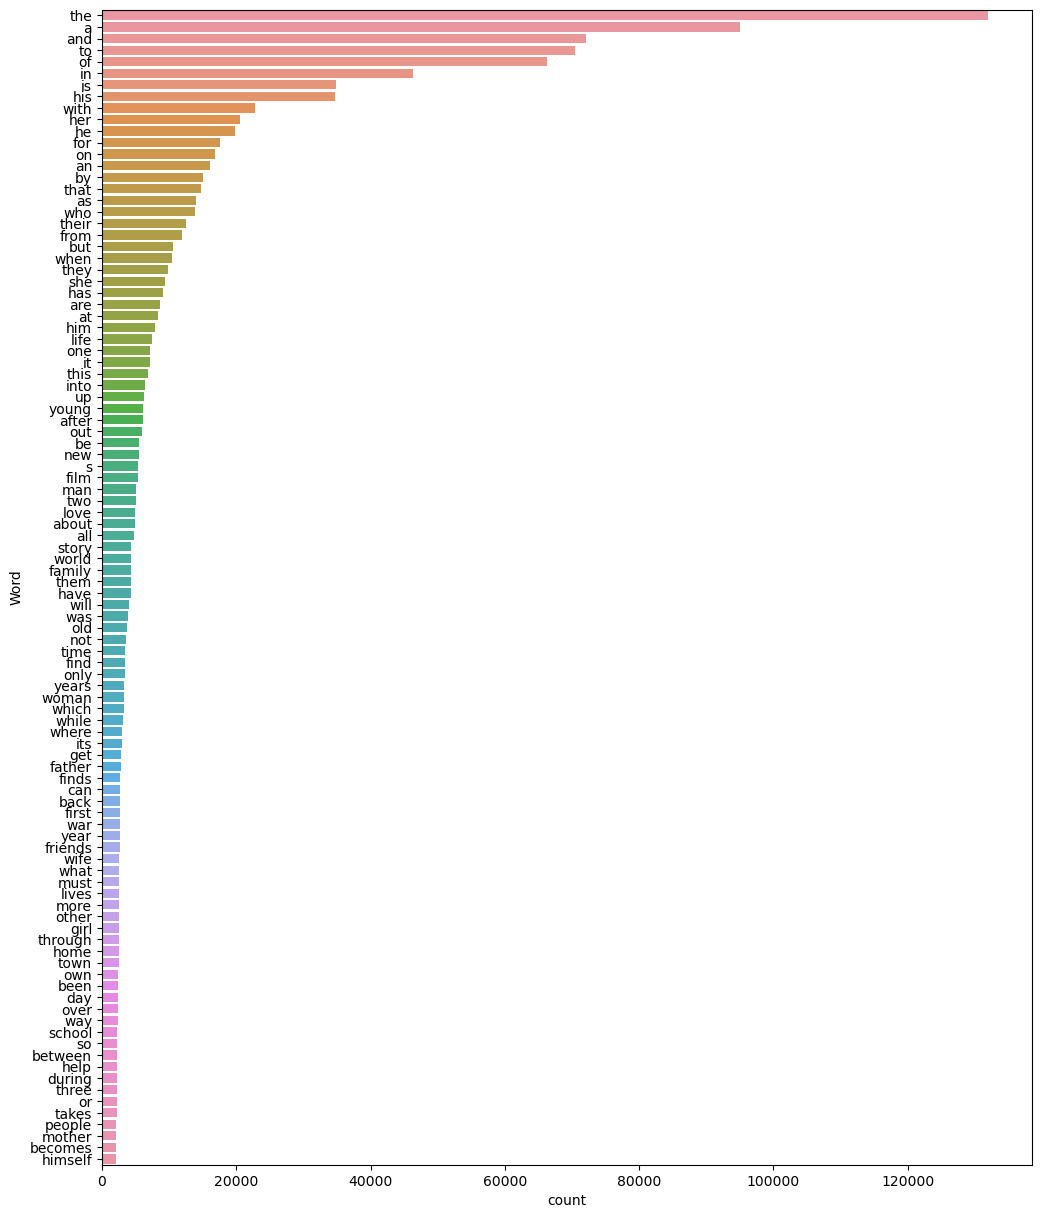

In [28]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(data['overview_clean'], 100)

In [29]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

data['overview_clean'] = data['overview_clean'].apply(lambda x: remove_stopwords(x))

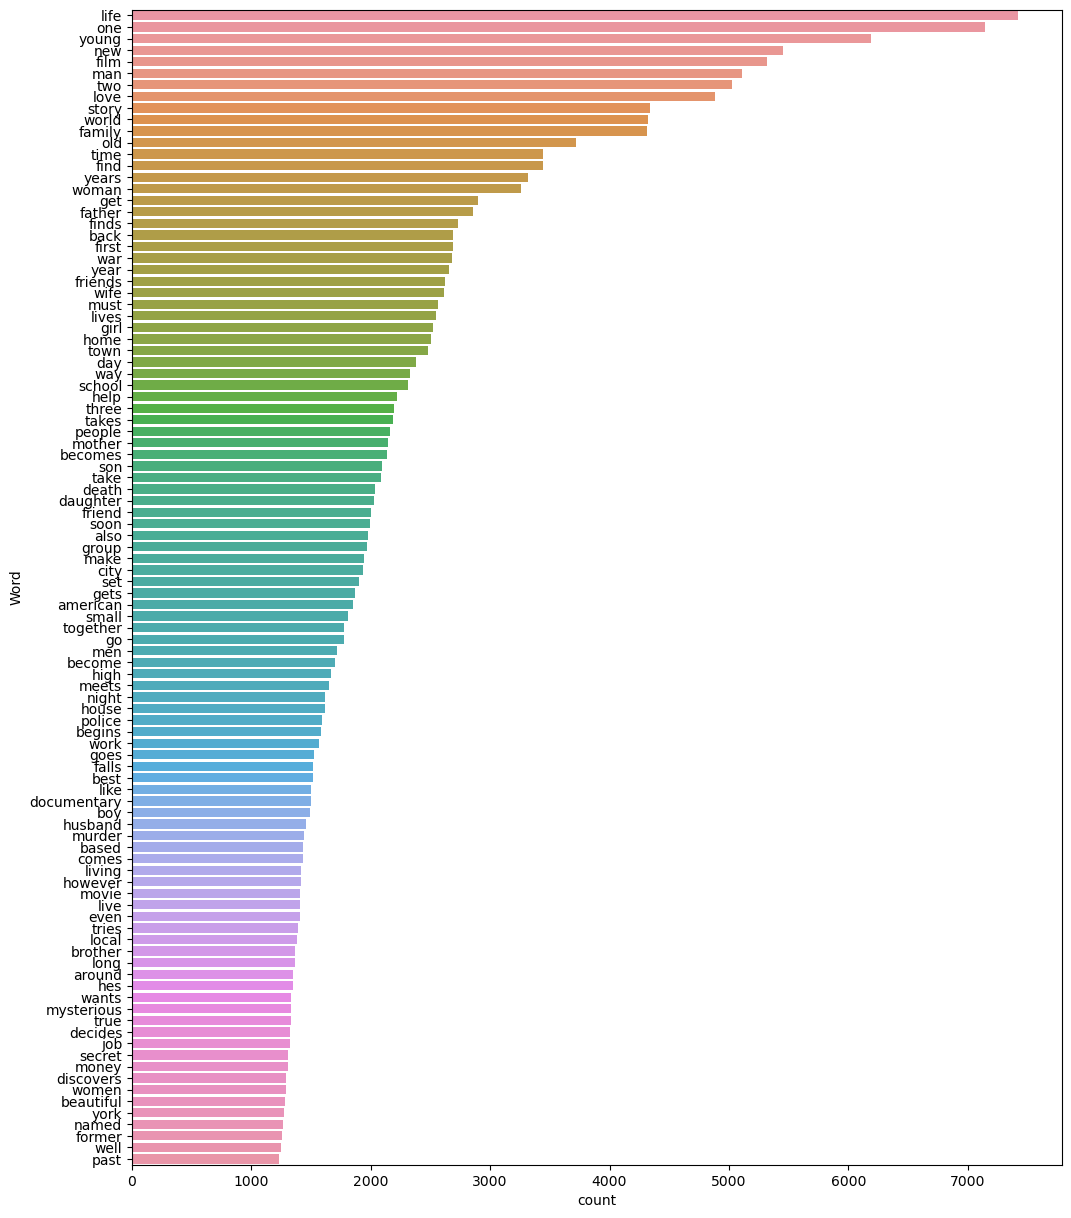

In [30]:
freq_words(data['overview_clean'], 100)


In [31]:

# Split the dataset into input (overview) and target (genres) columns
overview = data['overview_clean']


In [32]:
data['target'].value_counts()

[Drama]                                                                   4910
[Comedy]                                                                  3372
[Documentary]                                                             2685
[Drama, Romance]                                                          1291
[Comedy, Drama]                                                           1110
                                                                          ... 
[Animation, Drama, Science Fiction, Thriller]                                1
[Comedy, Romance, Animation, Music]                                          1
[Fantasy, Music, Romance, Adventure]                                         1
[Action, Adventure, Drama, Fantasy, Foreign, Romance, Science Fiction]       1
[Family, Animation, Romance, Comedy]                                         1
Name: target, Length: 4048, dtype: int64

In [33]:
data['overview_clean'].tail()

45459    year ad worlds dangerous women banished remote asteroid million light years earth kira murphy doesnt belong wrongfully accused crime commit shes thrown interplanetary prison left defenses kiras fighter soon finds middle female gang war everyone wants piece action piece caged heat takes women pri...
45460                                                                                                 yet another version classic epic enough variation make interesting story characters quite different usual particular uma thurmans special maid marian photography also great giving story somewhat darker tone
45461                                                                                                                                                                                                                                                                                       rising falling man woman
45462                                                                    

In [34]:
genres = data['target']

In [35]:

# Preprocess the text data (e.g., remove stopwords, tokenize, etc.)

# Convert the target labels to a multi-label binary format
mlb = MultiLabelBinarizer()
target_binary = mlb.fit_transform(genres)

In [36]:
target_binary

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [37]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(overview, target_binary, test_size=0.5, random_state=42)


In [38]:
# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [39]:
X_train_vectorized.shape

(21163, 10000)

In [42]:
# Apply TruncatedSVD for dimensionality reduction
svd = TruncatedSVD(n_components=100)  # Adjust the number of components as per your requirement
X_train_reduced = svd.fit_transform(X_train_vectorized)
X_test_reduced = svd.transform(X_test_vectorized)

In [45]:
models = [LogisticRegression()]

In [50]:
for model_name in models:
    print("Model :", model_name )
    model = OneVsRestClassifier(model_name)
    model.fit(X_train_reduced, y_train)
    # Make predictions on the testing set
    y_pred = model.predict(X_test_reduced)
    # Inverse transform the predicted binary labels to the original genre labels
    predicted_genres = mlb.inverse_transform(y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')  # Micro-average F1-score for multi-label classification
    print("Accuracy:", accuracy)
    print("F1-score:", f1)
    
    
    y_pred_prob = model.predict_proba(X_test_reduced)
    # Inverse transform the predicted binary labels to the original genre labels
    predicted_genres = mlb.inverse_transform(y_pred)
    
    print("Tuned Threshold - 0.4")
    t = 0.4 # threshold value
    y_pred_new = (y_pred_prob >= t).astype(int)
    accuracy = accuracy_score(y_test, y_pred_new)
    f1 = f1_score(y_test, y_pred_new, average='micro')  # Micro-average F1-score for multi-label classification
    print("Accuracy:", accuracy)
    print("F1-score:", f1)
    
    print("Tuned Threshold - 0.2")
    t = 0.2 # threshold value
    y_pred_new = (y_pred_prob >= t).astype(int)
    accuracy = accuracy_score(y_test, y_pred_new)
    f1 = f1_score(y_test, y_pred_new, average='micro')  # Micro-average F1-score for multi-label classification
    print("Accuracy:", accuracy)
    print("F1-score:", f1)
    
    print("Tuned Threshold - 0.3")
    t = 0.3 # threshold value
    y_pred_new = (y_pred_prob >= t).astype(int)
    accuracy = accuracy_score(y_test, y_pred_new)
    f1 = f1_score(y_test, y_pred_new, average='micro')  # Micro-average F1-score for multi-label classification
    print("Accuracy:", accuracy)
    print("F1-score:", f1)
    
    
    

Model : LogisticRegression()


/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 13 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 19 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarn

Accuracy: 0.13631638631638632
F1-score: 0.35573824399868464
Tuned Threshold - 0.4
Accuracy: 0.15516915516915517
F1-score: 0.447179371374536
Tuned Threshold - 0.2
Accuracy: 0.06728406728406729
F1-score: 0.5219203948475387
Tuned Threshold - 0.3
Accuracy: 0.13045738045738045
F1-score: 0.5058514955128732


In [193]:
for model_name in models:
    print("Model :", model_name )
    model = OneVsRestClassifier(model_name)
    model.fit(X_train_reduced, y_train)
    # Make predictions on the testing set
    y_pred = model.predict(X_test_reduced)
    # Inverse transform the predicted binary labels to the original genre labels
    predicted_genres = mlb.inverse_transform(y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')  # Micro-average F1-score for multi-label classification
    print("Accuracy:", accuracy)
    print("F1-score:", f1)
    
    
    y_pred_prob = model.predict_proba(X_test_reduced)
    # Inverse transform the predicted binary labels to the original genre labels
    predicted_genres = mlb.inverse_transform(y_pred)
    
    print("Tuned Threshold - 0.4")
    t = 0.4 # threshold value
    y_pred_new = (y_pred_prob >= t).astype(int)
    accuracy = accuracy_score(y_test, y_pred_new)
    f1 = f1_score(y_test, y_pred_new, average='micro')  # Micro-average F1-score for multi-label classification
    print("Accuracy:", accuracy)
    print("F1-score:", f1)
    
    print("Tuned Threshold - 0.2")
    t = 0.2 # threshold value
    y_pred_new = (y_pred_prob >= t).astype(int)
    accuracy = accuracy_score(y_test, y_pred_new)
    f1 = f1_score(y_test, y_pred_new, average='micro')  # Micro-average F1-score for multi-label classification
    print("Accuracy:", accuracy)
    print("F1-score:", f1)
    
    print("Tuned Threshold - 0.3")
    t = 0.3 # threshold value
    y_pred_new = (y_pred_prob >= t).astype(int)
    accuracy = accuracy_score(y_test, y_pred_new)
    f1 = f1_score(y_test, y_pred_new, average='micro')  # Micro-average F1-score for multi-label classification
    print("Accuracy:", accuracy)
    print("F1-score:", f1)
    
    

Model : LogisticRegression()


/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 13 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 19 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarn

Accuracy: 0.13735588735588736
F1-score: 0.3553207596853296
Tuned Threshold - 0.4
Accuracy: 0.15724815724815724
F1-score: 0.4482481267726869
Tuned Threshold - 0.2
Accuracy: 0.06761481761481762
F1-score: 0.5218642009900065
Tuned Threshold - 0.3
Accuracy: 0.1285201285201285
F1-score: 0.5054546311349873
Model : DecisionTreeClassifier()


/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 13 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 19 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarn

Accuracy: 0.05301455301455302
F1-score: 0.33284687431932036
Tuned Threshold - 0.4
Accuracy: 0.05310905310905311
F1-score: 0.333746466623179
Tuned Threshold - 0.2
Accuracy: 0.05310905310905311
F1-score: 0.3337138136081488
Tuned Threshold - 0.3
Accuracy: 0.05310905310905311
F1-score: 0.333746466623179
Model : RandomForestClassifier()


/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 13 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 19 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarn

Accuracy: 0.12856737856737857
F1-score: 0.31822038212237413
Tuned Threshold - 0.4
Accuracy: 0.1437818937818938
F1-score: 0.4336833379386571
Tuned Threshold - 0.2
Accuracy: 0.04677754677754678
F1-score: 0.47573260073260076
Tuned Threshold - 0.3
Accuracy: 0.10574560574560575
F1-score: 0.4869687668459905
Model : AdaBoostClassifier()


/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 13 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 19 is present in all training examples.
  warnings.warn(
/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarn

Accuracy: 0.13797013797013796
F1-score: 0.40218126231002144
Tuned Threshold - 0.4
Accuracy: 0.0
F1-score: 0.19343199726816443
Tuned Threshold - 0.2
Accuracy: 0.0
F1-score: 0.19248393226998056
Tuned Threshold - 0.3
Accuracy: 0.0
F1-score: 0.19271786538954927
Model : GradientBoostingClassifier()


KeyboardInterrupt: 

In [1]:
!pip install --upgrade tensorflow


In [2]:
!conda install tensorflow -y

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::holoviews==1.15.0=py39hecd8cb5_0
  - defaults/noarch::nbclassic==0.3.5=pyhd3eb1b0_0
  - defaults/osx-64::jupyterlab==3.4.4=py39hecd8cb5_0
  - defaults/osx-64::anaconda==2022.10=py39_0
  - defaults/osx-64::hvplot==0.8.0=py39hecd8cb5_0
  - defaults/osx-64::plotly==5.9.0=py39hecd8cb5_0
  - defaults/osx-64::qtconsole==5.3.2=py39hecd8cb5_0
  - defaults/osx-64::ipython==7.31.1=py39hecd8cb5_1
  - defaults/osx-64::sphinx==5.0.2=py39hecd8cb5_0
  - defaults/osx-64::_ipyw_jlab_nb_ext_conf==0.1.0=py39hecd8cb5_1
  - defaults/noarch::jupyterlab_pygments==0.1.2=py_0
  - defaults/osx-64::jupyter_server==1.18.1=py39hecd8cb5_0
  - defaults/osx-64::spyder-kernels==2.3.3=py39hecd8cb5_0
  - defaults/noarch::jupyterlab_server==2.10.3=pyhd3eb1b0_1
  - defaults/osx-64::nbconvert==6.4.4=py39hecd8cb5_0
  - defaults/osx-64::numpydoc==1.4.0=py

scipy-1.7.3          | 15.7 MB   | ##################################### | 100% 
blinker-1.4          | 23 KB     | ##################################### | 100% 
gast-0.4.0           | 13 KB     | ##################################### | 100% 
aiosignal-1.2.0      | 12 KB     | ##################################### | 100% 
_anaconda_depends-20 | 69 KB     | ##################################### | 100% 
pygments-2.15.1      | 1.8 MB    | ##################################### | 100% 
opt_einsum-3.3.0     | 57 KB     | ##################################### | 100% 
keras-2.9.0          | 1.5 MB    | ##################################### | 100% 
async-timeout-4.0.2  | 13 KB     | ##################################### | 100% 
tensorboard-2.9.0    | 5.5 MB    | ##################################### | 100% 
termcolor-2.1.0      | 12 KB     | ##################################### | 100% 
abseil-cpp-20211102. | 933 KB    | ##################################### | 100% 
google-auth-2.6.0    | 83 KB

In [3]:
import tensorflow as tf
print(tf.__version__)

/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.9.1


In [51]:
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report


In [52]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [53]:

# Pad sequences to ensure equal length
max_sequence_length = 1000  # Set the maximum sequence length as needed
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')

In [54]:
# Create the deep learning model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_sequence_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(mlb.classes_), activation='sigmoid'))

In [55]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])


/Users/mohamednoordeenalaudeen/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [57]:
# Train the model
model.fit(X_train_padded, y_train, batch_size=32, epochs=10, validation_data=(X_test_padded, y_test))


Epoch 1/10
662/662 [==============================] - 562s 847ms/step - loss: 0.1931 - accuracy: 0.2654 - val_loss: 0.1831 - val_accuracy: 0.2684
Epoch 2/10
662/662 [==============================] - 573s 866ms/step - loss: 0.1830 - accuracy: 0.2709 - val_loss: 0.1833 - val_accuracy: 0.2684
Epoch 3/10
662/662 [==============================] - 560s 846ms/step - loss: 0.1830 - accuracy: 0.2709 - val_loss: 0.1827 - val_accuracy: 0.2684
Epoch 4/10
662/662 [==============================] - 563s 851ms/step - loss: 0.1831 - accuracy: 0.2709 - val_loss: 0.1830 - val_accuracy: 0.2684
Epoch 5/10
662/662 [==============================] - 567s 857ms/step - loss: 0.1829 - accuracy: 0.2709 - val_loss: 0.1828 - val_accuracy: 0.2684
Epoch 6/10
662/662 [==============================] - 564s 852ms/step - loss: 0.1830 - accuracy: 0.2709 - val_loss: 0.1826 - val_accuracy: 0.2684
Epoch 7/10
662/662 [==============================] - 593s 895ms/step - loss: 0.1830 - accuracy: 0.2709 - val_loss: 0.1834 -

In [ ]:


# Pad sequences to ensure equal length
max_sequence_length = 1000  # Set the maximum sequence length as needed
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')

# Create the deep learning model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_sequence_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(mlb.classes_), activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, batch_size=32, epochs=10, validation_data=(X_test_padded, y_test))

# Make predictions
y_pred = model.predict(X_test_padded)

# Convert the probability predictions to binary labels
y_pred_labels = mlb.inverse_transform((y_pred > 0.5).astype(int))
y_test_labels = mlb.inverse_transform(y_test)

# Print classification report
print(classification_report(y_test_labels, y_pred_labels))
